In [1]:
from fipy import Grid3D, Grid2D, CellVariable, FaceVariable, Viewer, numerix
from fipy import DiffusionTerm, ExplicitDiffusionTerm, TransientTerm, ImplicitDiffusionTerm
from IPython.display import clear_output

import numpy as np

import plotting_utils
import parameterfunctions as fct
import helper_functions
from parameters import *

from tqdm.notebook import trange, tqdm

--------------------------------------------------------------------------
The library attempted to open the following supporting CUDA libraries,
but each of them failed.  CUDA-aware support is disabled.
libcuda.so.1: cannot open shared object file: No such file or directory
libcuda.dylib: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.so.1: cannot open shared object file: No such file or directory
/usr/lib64/libcuda.dylib: cannot open shared object file: No such file or directory
If you are not interested in CUDA-aware support, then run with
--mca opal_warn_on_missing_libcuda 0 to suppress this message.  If you are interested
in CUDA-aware support, then try setting LD_LIBRARY_PATH to the location
of libcuda.so.1 to get passed this issue.
--------------------------------------------------------------------------


In [2]:
m = 2/3

dz = helper_functions.create_dz(N_z, m, L_z)
dy = helper_functions.create_dy(N_y, m, L_y)

mesh = Grid3D(nx = N_x, ny = N_y, nz = N_z, dx = dx, dy = dy, dz = dz)

x = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[0])
y = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[1])
z = CellVariable(mesh = mesh, value = numerix.array(mesh.cellCenters)[2])

temperature = CellVariable(mesh = mesh, name = 'temperature', value=T_A)
pressure = CellVariable(mesh = mesh, name = 'pressure')
v_x = CellVariable(mesh = mesh, name = 'x-velocity', value=0.0)
v_y = CellVariable(mesh = mesh, name = 'y-velocity', value=0.0)
v_z = CellVariable(mesh = mesh, name = 'z-velocity', value=0.0)
sensible_heat = CellVariable(mesh = mesh, name = 'sensible heat', value=0.0, hasOld=True)

velocity = CellVariable(mesh = mesh, name = 'velocity', rank = 1, value = numerix.array([numerix.array(v_x), numerix.array(v_y), numerix.array(v_z)]))

0.0002
0.0002


/home/nils/.local/lib/python3.9/site-packages/fipy/tools/dimensions/physicalField.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  value = numerix.array(normalized)
/home/nils/.local/lib/python3.9/site-packages/fipy/meshes/builders/grid3DBuilder.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numerix.array((self.ds[0], self.ds[1], self.ds[2]))[..., numerix.newaxis]


In [3]:
#starting values:
x_pos = 0.0001
layer = 3
hatch = 2.5
time = 0.0
relaxation = 0.99

#layer of laser impact:
N = mesh.nz -1

#measure here:
middle = -N_x*8+round(N_x/2)-5#-round(N_y/2*N_x)+round(N_x/2)#-int(N_x*N_y-N_x*N_y/2)

#lists of measuremnts
c_measure = []
k_measure = []
t_measure = []
time_measure = []

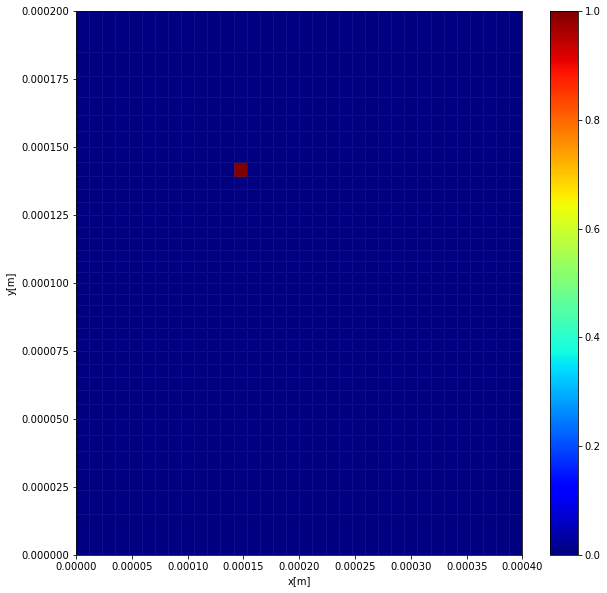

In [4]:
cell = CellVariable(mesh = mesh, value = 0.0)
dummie = np.zeros(len(np.array(cell)))
dummie[middle] = 1.0
cell.setValue(dummie)
viewer = plotting_utils.plot_2d_xy(cell, N)

In [5]:
liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
liquid_old = liquid
molten_cells = CellVariable(name = 'molten', mesh = mesh, value = 0.0)
source_term = CellVariable(name = 'source', mesh = mesh, value = 0.0)
zero = numerix.zeros(temperature.faceValue[mesh.facesTop].shape[0])
heat_face = FaceVariable(mesh = mesh)

sweeps = 10

for i in trange(time_steps):
    
    sensible_heat.updateOld()
    #print(i)
    #print(time)
    
    #setting new source term:
    laser_factor = CellVariable(mesh = mesh, value = ((1-liquid)*steel_powder_absoprtion+liquid*steel_liquid_absoprtion)*distribution_factor*laser_power/(numerix.pi*beam_radius**2*layer_thickness))
    source_value = laser_factor*numerix.exp(-distribution_factor*((x-x_pos)**2+(y-hatch*hatch_width)**2)/beam_radius**2)
    source = numerix.where(numerix.absolute(z-layer*layer_thickness) < layer_thickness, source_value, 0.0)
    source_term.setValue(source)
    
    #determine the liquid/solid/molten state
    liquid_old.setValue(numerix.array(liquid))
    liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
    molten_cells = fct.update_molten_cells(molten_cells, liquid)
    
    #update material paramters:
    c = fct.get_specific_heat(temperature, liquid, molten_cells, argon_density, steel_density, packing_efficiency, steel_T_S, steel_fluid_c)
    k = fct.get_thermal_conductivity(temperature, packing_efficiency, molten_cells, liquid, steel_cond_fluid, steel_T_S, N_IH)
    rho = fct.get_effective_density(argon_density, steel_density, packing_efficiency)*(1-liquid) + liquid*steel_density_liquid
    alpha = k/(rho*c)
    
    #saving old heat for temperature change:
    heat_old = numerix.array(sensible_heat) 
    
    heat_radiation = -c.faceValue*rho.faceValue*sigma*steel_emissivity*(temperature.faceValue**4-T_A**4)/k.faceValue
    heat_face.setValue(heat_radiation)
    #sensible_heat.faceGrad.constrain(numerix.stack((zero, zero, heat_face)), where = mesh.facesBack)
    sensible_heat.faceGrad.constrain(heat_face, where = mesh.facesBack)
    #sensible_heat.faceGrad.constrain(heat_face, where = mesh.exteriorFaces)
    sensible_heat.constrain(0.0, where = mesh.facesLeft | mesh.facesRight | mesh.facesBottom | mesh.facesTop |mesh.facesFront)
    
    konv_diff_eq = TransientTerm(var = sensible_heat) == DiffusionTerm(var = sensible_heat, coeff=alpha.harmonicFaceValue) + source_term - (liquid-liquid_old)*steel_latent_heat*rho

    for i in range(sweeps):
        res = konv_diff_eq.sweep(dt = dt, underRelaxation=relaxation)
        
    #calculate temperature change and add:
    temperature.setValue(numerix.array(temperature) +1/(c*rho)*(sensible_heat-heat_old)) 
    
    #updating laser position
    x_pos +=dt*scanning_speed
    time += dt
    #clear_output()
    if x_pos > 0.0003:
        break
        
    k_measure.append(numerix.array(k)[middle])
    c_measure.append(numerix.array(c)[middle])
    t_measure.append(numerix.array(temperature)[middle])
    time_measure.append(time)

    if x_pos >= L_x:
        
        hatch += 1
        x_pos = 0.0
        break
        
        if hatch == hatches:
            
            layer += 1
            hatch = 0
            
            if layer == layers:
                
                break

  0%|          | 0/100 [00:00<?, ?it/s]

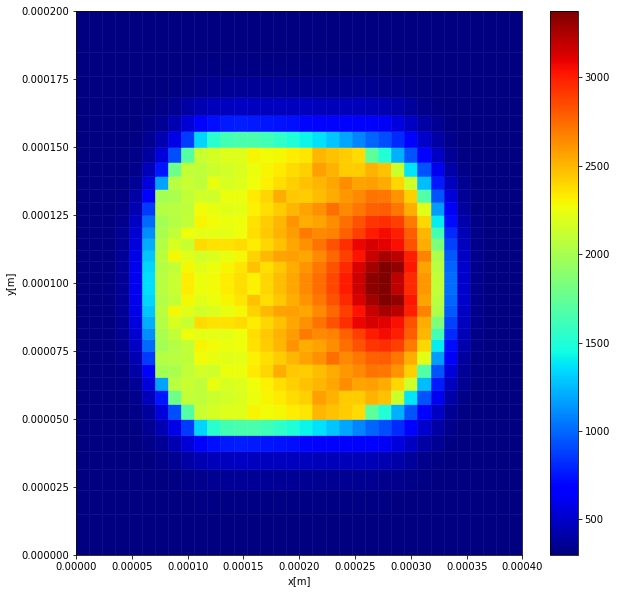

In [6]:
plotting_utils.plot_2d_xy(temperature, N)

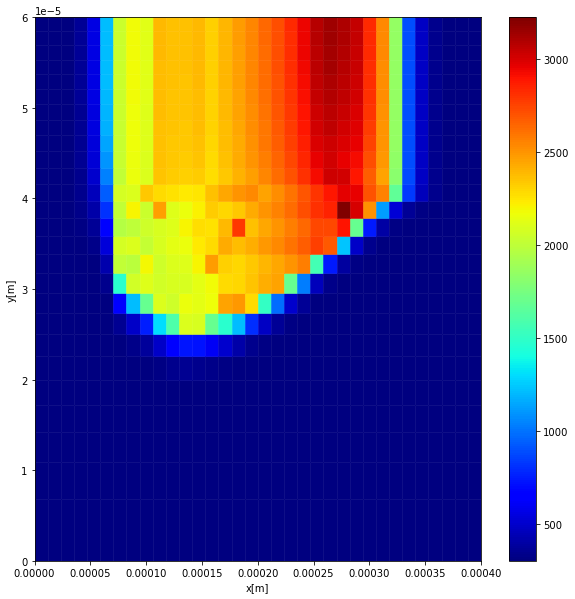

In [7]:
plotting_utils.plot_2d_xz(temperature, 13)

In [8]:
data = np.array(temperature)
np.save('temperature', data)

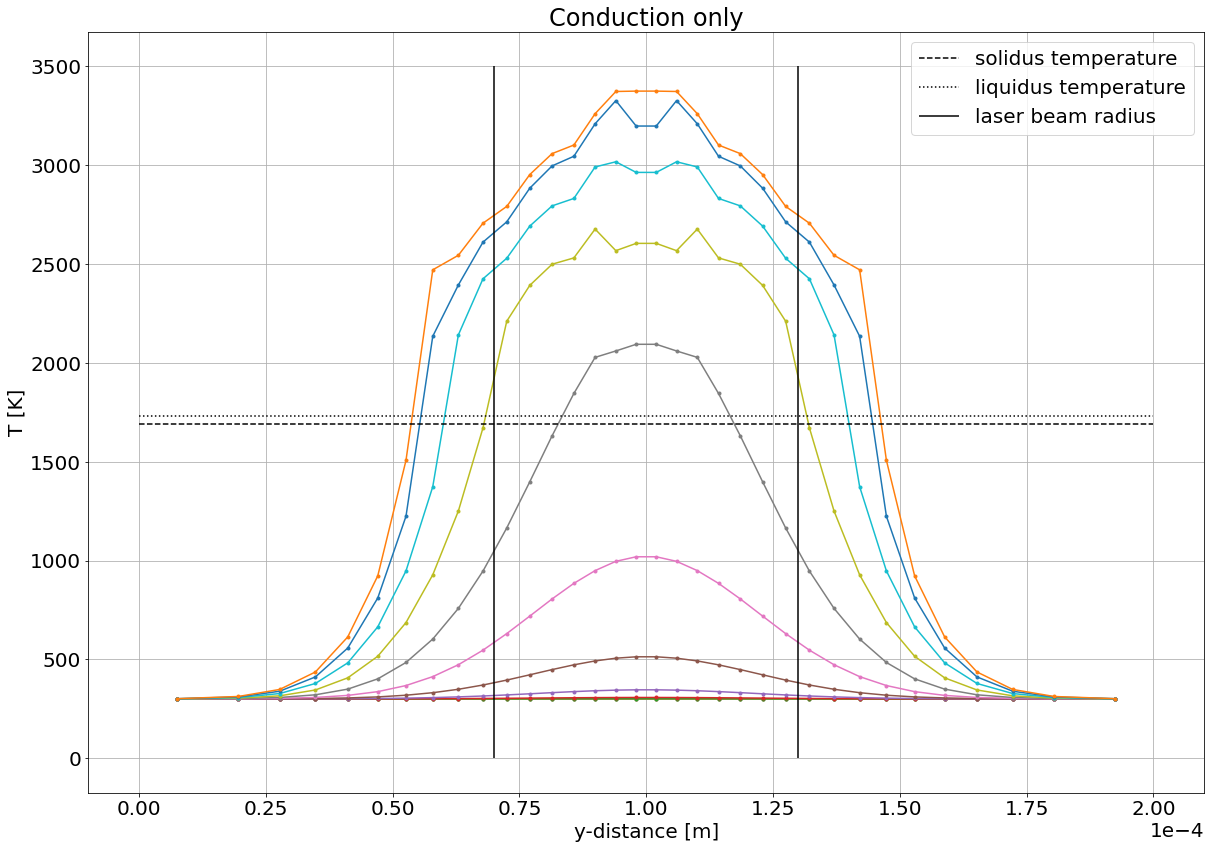

In [19]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

data = np.load('temperature.npy')

temp_final = data.reshape((N_z, N_y, N_x))
y_coordinates = np.array(mesh.cellCenters[1]).reshape((N_z, N_y, N_x))

#N_y_temp = 7
#plt.plot(y_coordinates[-1, :, -N_y_temp], temp_final[-1, :, -N_y_temp], marker = 'd', linestyle = '-')

plt.figure(figsize = (20, 14))

for N_y_temp in range(0, 12):
    
    plt.plot(y_coordinates[-1, :, -N_y_temp], temp_final[-1, :, -N_y_temp], marker = '.', linestyle = '-')

plt.hlines(steel_T_S, 0, 2e-4, 'k',linestyle = '--', label = 'solidus temperature')
plt.hlines(steel_T_L, 0, 2e-4, 'k',linestyle = 'dotted', label = 'liquidus temperature')
plt.vlines([1e-4 + beam_radius, 1e-4 - beam_radius], 0, 3500, color = 'black', linestyle = '-', label = 'laser beam radius')
plt.grid()
plt.xlabel('y-distance [m]')
plt.ylabel('T [K]')
plt.title('Conduction only')
#plt.ylim((1693, 3093))
#plt.yticks([1693 + i* 200 for i in range(8)])
plt.ticklabel_format(axis = 'x', style = 'sci', scilimits = (0,0))
#plt.legend(loc = 'lower left')
plt.legend()
plt.savefig('conductions.png')

In [10]:
remaining = 0.005 - time
dt = 0.0001
time_steps = int(remaining / dt)

source_term.setValue(0.0)

for i in trange(time_steps):
    
    sensible_heat.updateOld()
    
    #determine the liquid/solid/molten state
    liquid_old.setValue(numerix.array(liquid))
    liquid = fct.get_liquid_fraction(temperature, mesh, steel_T_S, steel_T_L)
    molten_cells = fct.update_molten_cells(molten_cells, liquid)
    
    #update material parameters:
    c = fct.get_specific_heat(temperature, liquid, molten_cells, argon_density, steel_density, packing_efficiency, steel_T_S, steel_fluid_c)
    k = fct.get_thermal_conductivity(temperature, packing_efficiency, molten_cells, liquid, steel_cond_fluid, steel_T_S, N_IH)
    rho = fct.get_effective_density(argon_density, steel_density, packing_efficiency)*(1-liquid) + liquid*steel_density_liquid
    alpha = k/(rho*c)

    #saving old heat for temperature change:
    heat_old = numerix.array(sensible_heat) 
    
    heat_radiation = -c.faceValue*rho.faceValue*sigma*steel_emissivity*(temperature.faceValue**4-T_A**4)/k.faceValue
    heat_face.setValue(heat_radiation)
    #sensible_heat.faceGrad.constrain(numerix.stack((zero, zero, heat_face)), where = mesh.facesBack)
    sensible_heat.faceGrad.constrain(heat_face, where = mesh.facesBack)
    #sensible_heat.faceGrad.constrain(heat_face, where = mesh.exteriorFaces)
    sensible_heat.constrain(0.0, where = mesh.facesLeft | mesh.facesRight | mesh.facesBottom | mesh.facesTop |mesh.facesFront)
    
    konv_diff_eq = TransientTerm(var = sensible_heat) == DiffusionTerm(var = sensible_heat, coeff=alpha.harmonicFaceValue) + source_term - (liquid-liquid_old)*steel_latent_heat*rho

    for i in range(sweeps):
        res = konv_diff_eq.sweep(dt = dt, underRelaxation=relaxation)
        
    #calculate temperature change and add:
    temperature.setValue(numerix.array(temperature) +1 / (c*rho)*(sensible_heat-heat_old)) 
    
    #updating laser position
    time += dt
    
    k_measure.append(numerix.array(k)[middle])
    c_measure.append(numerix.array(c)[middle])
    t_measure.append(numerix.array(temperature)[middle])
    time_measure.append(time)
    
c_measure = np.array(c_measure)
k_measure = np.array(k_measure)
t_measure = np.array(t_measure)
time_measure = np.array(time_measure)

  0%|          | 0/47 [00:00<?, ?it/s]

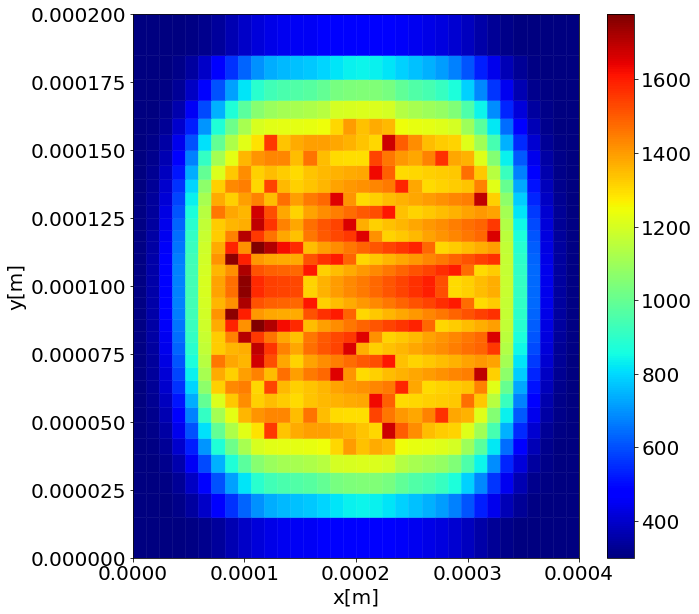

In [11]:
plotting_utils.plot_2d_xy(temperature, N)

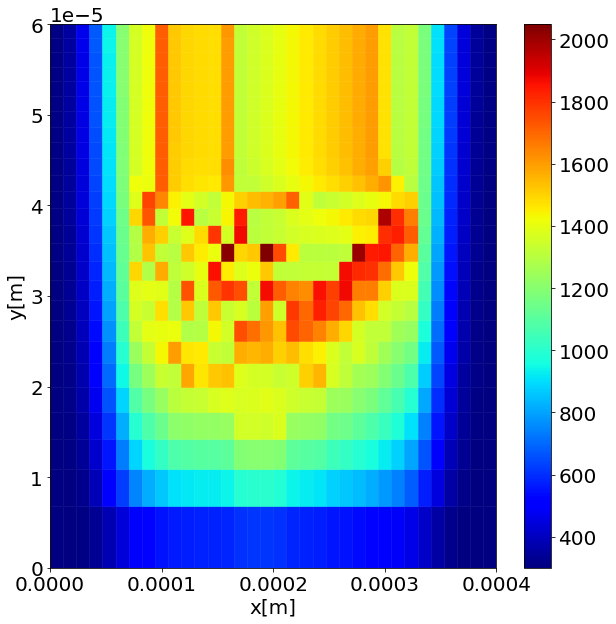

In [12]:
plotting_utils.plot_2d_xz(temperature, 15)

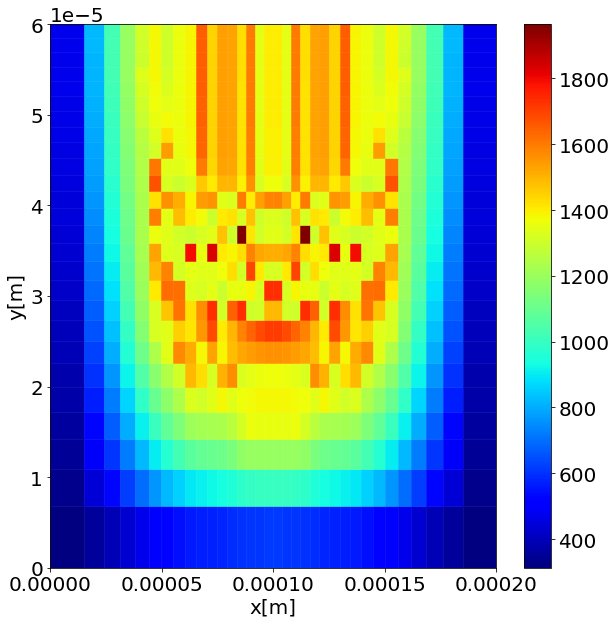

In [13]:
plotting_utils.plot_2d_yz(temperature, 15)

In [14]:
import pandas as pd

df = pd.DataFrame([time_measure, t_measure, c_measure, k_measure], index = ['time', 'temperature', 'specific heat', 'heat conductivity'])
df.to_csv('measurement.csv')

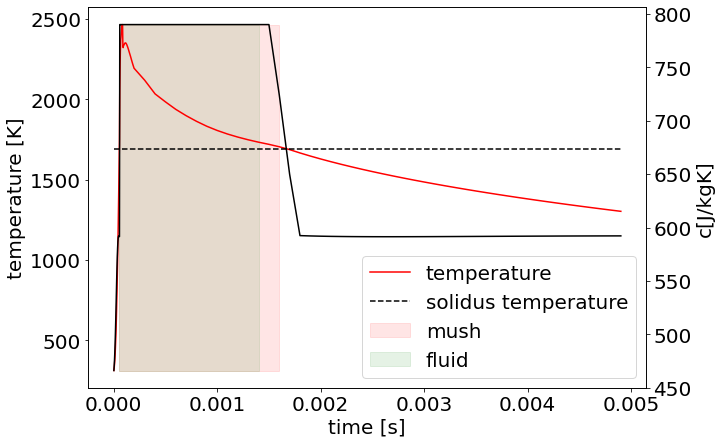

In [15]:
fig, ax1 = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax1.plot(time_measure, t_measure, 'r-', label = 'temperature')
ax1.set_ylabel('temperature [K]')
ax1.set_xlabel('time [s]')
ax1.hlines(steel_T_S, 0, time_measure[-1], 'k',linestyle = '--', label = 'solidus temperature')
#ax1.hlines(steel_T_L, 0, time_measure[-1], 'y',linestyle = '--',label = 'liquidus temperature')
mask = t_measure>steel_T_S
ax1.fill_betweenx([np.min(t_measure), np.max(t_measure)], time_measure[mask][0], time_measure[mask][-1], color = 'red', alpha = 0.1, label = 'mush')

mask = t_measure>steel_T_L
ax1.fill_betweenx([np.min(t_measure), np.max(t_measure)], time_measure[mask][0], time_measure[mask][-1], color = 'green', alpha = 0.1, label = 'fluid')

ax2 = ax1.twinx()
ax2.plot(time_measure, c_measure, 'k-')
ax2.set_ylabel('c[J/kgK]')

ax1.legend(loc = 'lower right')
plt.savefig('c.png')

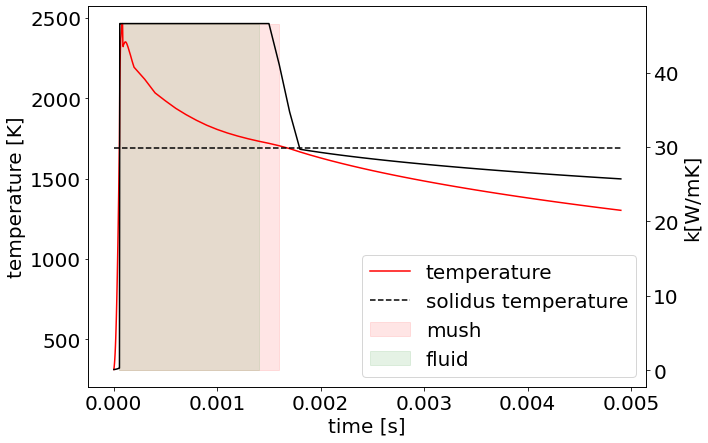

In [16]:
fig, ax1 = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(10)

ax1.plot(time_measure, t_measure, 'r-', label = 'temperature')
ax1.set_ylabel('temperature [K]')
ax1.set_xlabel('time [s]')
ax1.hlines(steel_T_S, 0, time_measure[-1], 'k',linestyle = '--', label = 'solidus temperature')
mask = t_measure>steel_T_S
ax1.fill_betweenx([np.min(t_measure), np.max(t_measure)], time_measure[mask][0], time_measure[mask][-1], color = 'red', alpha = 0.1, label = 'mush')

mask = t_measure>steel_T_L
ax1.fill_betweenx([np.min(t_measure), np.max(t_measure)], time_measure[mask][0], time_measure[mask][-1], color = 'green', alpha = 0.1, label = 'fluid')

ax2 = ax1.twinx()
ax2.plot(time_measure, k_measure, 'k-', label = 'k')
ax2.set_ylabel('k[W/mK]')

ax1.legend(loc = 'lower right')
plt.savefig('k.png')